## <p style="text-align: center;"> OPEN-IIT </p>
### <p style="text-align: center;"> DATA ANALYTICS </p>

In this challenge, we aim to create a predictive solution that leverages historical and operational data to enhance decision-making in airline operations. The primary objectives are twofold: firstly, to develop a model that accurately forecasts flight delays based on historical data, helping airlines proactively allocate resources; and secondly, to design a system that can reschedule flights dynamically to minimize overall delays across routes, optimizing the utilization of fleet and crew.


In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn 
!pip install tensorflow
!pip install kagglehub
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install optuna
!pip install scipy

In [11]:
import pandas as pd
import numpy as np
import kagglehub
import random
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px

#### DATASET

In [ ]:
path = kagglehub.dataset_download("patrickzel/flight-delay-and-cancellation-dataset-2019-2023")
file_path = os.path.join(path, "flights_sample_3m.csv")
data = pd.read_csv(file_path)
pd.set_option('display.max_columns', None)
display(data)

In [ ]:
#data description
with open(f'{path}\dictionary.html', 'r') as file:
    html_content = file.read()
display(HTML(html_content))

Convert FL_DATE to "datetime" recognized by pandas

In [4]:
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'], format='%Y-%m-%d').copy()

In [ ]:
data.describe()

Toggle assertions on or off

In [12]:
TEST: bool = True

Dropping cancelled and diverted flights, they are outside of our scope, we only want delayed flights

In [13]:
num_cancelled_or_diverted = len(data[(data['CANCELLED'] == 1) | (data['DIVERTED'] == 1)])
cancelled_or_diverted_counts = data[(data['CANCELLED'] == 1) | (data['DIVERTED'] == 1)]["FL_DATE"].dt.strftime('%Y-%m').value_counts().sort_index()
data = data[(data['CANCELLED'] != 1) & (data['DIVERTED'] != 1)]

Attempt to drop duplicates (we found out there aren't any)

In [15]:
data_len_with_duplicates = len(data)
data.drop_duplicates(inplace=True)
if TEST:
  assert len(data) == data_len_with_duplicates  # no duplicates

Visualizing the presence of delay components

In [16]:
def split_by_components(df: pd.DataFrame):
  # Finding: if there is one component, it has all components
  isna_mask = df[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
                  'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                  'DELAY_DUE_LATE_AIRCRAFT']].isna().any(axis=1)

  delay_components_df = df[~isna_mask]
  no_delay_components_df = df[isna_mask]

  return delay_components_df, no_delay_components_df

In [ ]:
delay_components_df, no_delay_components_df = split_by_components(data)

ratio_components = len(delay_components_df) / len(data)

fig, ax = plt.subplots()
labels = ["Has delay components", "Missing delay components", "Cancelled or Diverted"]
sizes = [len(delay_components_df), len(no_delay_components_df), num_cancelled_or_diverted]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal') 

About 79.3% data does not contain any reason for the delay and hence we can't use that

In [ ]:
components_counts = delay_components_df["FL_DATE"].dt.strftime('%Y-%m').value_counts().sort_index()
no_components_counts = no_delay_components_df["FL_DATE"].dt.strftime('%Y-%m').value_counts().sort_index()
all_dates = pd.concat([components_counts, no_components_counts, cancelled_or_diverted_counts], axis=1, keys=['Components', 'No Components', "Cancelled or Diverted"])
all_dates.reset_index(inplace=True)
all_dates.columns = ['Date', 'Has Delay Components', 'Missing Delay Components', "Cancelled or Diverted"]

fig, ax = plt.subplots(figsize=(15, 8))
all_dates.set_index('Date').plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Unique Dates')
ax.set_ylabel('Count')
ax.set_title('Flight Delay Components Over Time')
plt.xticks(rotation=90)
plt.show()

clearly shows the delay status over the unique months

Ensure that delay components always sum to equal arrival delay

In [19]:
if TEST:
  def check_delay_components_sum_to_arr_delay(row) -> bool:
      components_delay = row[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
                            'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                            'DELAY_DUE_LATE_AIRCRAFT']].sum()
      return components_delay == row['ARR_DELAY']

  assert delay_components_df.apply(check_delay_components_sum_to_arr_delay, axis=1).all()

Set data to just the delay components to simplify referencing below

In [20]:
data = delay_components_df.copy()

Removing outliers using IQR method on the overall arrival delay

In [ ]:
# Boxplot before removing outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data['ARR_DELAY'])
plt.title('Box Plot of ARR_DELAY Column')
plt.xlabel('ARR_DELAY')
plt.show()

# Calculate Q1, Q3, IQR
Q1 = data['ARR_DELAY'].quantile(0.25)
Q3 = data['ARR_DELAY'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data_no_outliers = data[(data['ARR_DELAY'] >= lower_bound) & (data['ARR_DELAY'] <= upper_bound)]

print("Summary Statistics after Removing Outliers:")
print(data_no_outliers['ARR_DELAY'].describe())
print(data["ARR_DELAY"].describe())

print((len(data) - len(data_no_outliers)) / len(data))
print((len(data) - len(data_no_outliers)))

# Box plot after removing outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data_no_outliers['ARR_DELAY'])
plt.title('Box Plot of ARR_DELAY Column')
plt.xlabel('ARR_DELAY')
plt.ylabel("Overall Arrival Delay (mins)")
plt.show()

Calculating the Pearson Correlation on just the non-categorical attributes, since Pearson Correlation is invalid for categorical attributes

In [22]:
from scipy.stats import pearsonr

def calculate_pearson_score(df: pd.DataFrame, col: str, y) -> float:
  """
  Calculates the Pearson correlation coefficient between two columns in a DataFrame.

  Args:
    df: DataFrame.
    col: The name of the first column.
    y: The name of the second column.

  Returns:
    Pearson correlation coefficient.
  """
  try:
    corr,_ = pearsonr(df[col].values, y.values)
    return corr
  except:
    return 0

# Calculate the Pearson correlation coefficient for each column w/ ARR_DELAY
pearson_scores = {}
cols=['CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
      'DISTANCE']
for col in cols:
    pearson_scores[col] = calculate_pearson_score(data_no_outliers, col, data_no_outliers["ARR_DELAY"])

# Sort the Pearson correlation coefficients
sorted_pearson_scores = sorted(pearson_scores.items(), key=lambda x: x[1], reverse=True)

for col, score in sorted_pearson_scores:
    print(f"{col}: {score}")

# NOTE: ELAPSED TIME IS REDUNDANT

CRS_DEP_TIME: 0.070351400136903
TAXI_OUT: 0.05410605127602412
CRS_ARR_TIME: 0.05002847040250279
TAXI_IN: 0.02354168085730836
CRS_ELAPSED_TIME: -0.012206498859525686
DISTANCE: -0.022838335188191387


In [23]:
from scipy.stats import kruskal

cols = ['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
        'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY']

# Calculate the Kruskal-Wallis H statistic for each categorical variable
h_values = {}
for col in cols:
    h, p_value = kruskal(*[group['ARR_DELAY'] for name, group in data_no_outliers.groupby(col)])
    h_values[col] = h

# Sort the columns by their H values
sorted_cols = sorted(h_values, key=h_values.get, reverse=True)

print("Categorical columns ranked by their correlation with:")
for col in sorted_cols:
    print(f"{col}: {h_values[col]}")

# drop AIRLINE_DOT, AIRLINE_CODE, DOT_CODE bc redundant w/ AIRLINE
# drop ORIGIN_CITY, DEST_CITY bc redundant (basically) w/ ORIGIN, DEST

Categorical columns ranked by their correlation with:
FL_DATE: 11695.475421633384
FL_NUMBER: 8809.136394469862
DOT_CODE: 4954.9899978141175
AIRLINE: 4954.989997813885
AIRLINE_DOT: 4954.989997813885
AIRLINE_CODE: 4954.989997813885
ORIGIN: 4605.392992471976
ORIGIN_CITY: 4345.318673077497
DEST: 3988.8397909004916
DEST_CITY: 3744.0359485488907


In [26]:
X_df = data_no_outliers[
    [
        "FL_DATE",  # yyymmdd of flight (ordinal, discrete),
        "FL_NUMBER",
        "AIRLINE",  # name of airline (nominal, discrete)
        # Ignore AIRLINE_CODE because it is redundant
        "ORIGIN",  # origin airport code (nomincal, discrete)
        # Ignore ORIGIN_CITY because it is redundant
        "DEST",  # destination airport code (nomincal, discrete)
        # Ignore DEST_CITY because it is redundant
        "CRS_DEP_TIME",  # hhmm planned departure time (ordinal, discrete)
        "CRS_ARR_TIME",  # hhmm planned arrival time (ordinal, discrete)
        # Ignore CRS_ELAPSED_TIME because it is redundant since we have CRS_DEP_TIME and CRS_ARR_TIME
        "DISTANCE",  # miles between airports (ratio, discrete)
        "TAXI_IN",
        "TAXI_OUT"
    ]
]

Y_df = data_no_outliers[
    [
        # "CANCELLATION_CODE",  # reason for cancellation, NA if not cancelled (nominal, discrete)
        # Ignore CANCELLED because it is redundant, CANCELLATION_CODE provides more information
        # "DIVERTED",  # 1 if diverted, 0 if not (ordinal, discrete) NOTE: NOT SURE IF WE WANT TO KEEP
        # "AIR_TIME",  # Flight time, minutes (ratio, discrete)
        "DELAY_DUE_CARRIER",  # delay due to technical difficulties / damage / carrier efficiency (ratio, discrete)
        # Hypothesis: AIRLINE, ORIGIN, DEST may inform DELAY_DUE_CARRIER
        "DELAY_DUE_WEATHER",  # delay due to weather (ratio, discrete)
        # Hypothesis: FL_DATE, ORIGIN, DEST may inform DELAY_DUE_WEATHER
        "DELAY_DUE_SECURITY",  # delay due to security (ratio, discrete)
        # Hypothesis: FL_DATE, ORIGIN, CRS_DEP_TIME, DISTANCE may inform DELAY_DUE_SECURITY,
        "DELAY_DUE_NAS",  # not sure how this will do due to lacking info in features
        "DELAY_DUE_LATE_AIRCRAFT"  # delay due to late aircraft (ratio, discrete)
        # Hypothesis: AIRLINE, CRS_DEP_TIME may inform DELAY_DUE_LATE_AIRCRAFT
    ]
]

arr_only_y_df = data_no_outliers["ARR_DELAY"]

# AIRLINE_CODE, DOT_CODE, FL_NUMBER are ignored because they are unique identifiers
# TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN are ignored because they seem irrelevant NOTE: MAY WANT TO LOOK INTO THIS
# DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, ELAPSED_TIME are ignored because the individual delay contributions factor into them

# WARNING: DELAY_DUE_NAS might not have sufficient info to predict this. It is National Air System Delay, minutes.

Check if there are any NA values in X_df. There are none

In [27]:
df = data.copy()

In [ ]:
# Look for any NA values in X
if TEST:
  X_df.replace('', np.nan, inplace=True)
  pd.isna(X_df).sum().sum() == 0

Label encoding the airline and airport. ORIGIN and DEST should be encoded together to preserve the relationship between outbound and inbound same airports.

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import pandas as pd

# Assign integer labels to airline
airline_encoder = LabelEncoder()
X_df["AIRLINE"] = airline_encoder.fit_transform(X_df["AIRLINE"])

# Assign integer labels to airport code
airport_encoder = LabelEncoder()
# Use pd.concat to combine the 'ORIGIN' and 'DEST' columns
airport_encoder.fit(pd.concat([X_df["ORIGIN"], X_df["DEST"]]))
X_df["ORIGIN"] = airport_encoder.transform(X_df["ORIGIN"])
X_df["DEST"] = airport_encoder.transform(X_df["DEST"])
# assert X_df.loc[1, "ORIGIN"] == X_df.loc[3, "ORIGIN"] == X_df.loc[2, "DEST"]  # all MSP

X_df.head()

Converting hhmm time format to minutes past midnight, this way it'll help us run our models easily, instead of going to a datetime format and then again calculating the time difference in minutes/hours.

In [ ]:
def convert_hhmm_to_mins(hhmm_list):
  hours = []
  mins = []

  # Look at str length to determine number of hours and mins
  for s in hhmm_list:
    if len(s) == 1:
      hours.append(0)
      mins.append(int(s))
    elif len(s) == 2:
      hours.append(0)
      mins.append(int(s))
    elif len(s) == 3:
      hours.append(int(s[0]))
      mins.append(int(s[1:]))
    elif len(s) == 4:
        hours.append(int(s[:2]))
        mins.append(int(s[2:]))
    else:
      raise ValueError(s)

  # Calculate total minutes
  return np.array(hours) * 60 + np.array(mins)

# Convert hhmm times to minutes
X_df["CRS_DEP_TIME"] = X_df["CRS_DEP_TIME"].astype(str)
X_df["CRS_DEP_TIME"] = convert_hhmm_to_mins(X_df["CRS_DEP_TIME"])
# assert X_df["CRS_DEP_TIME"][:5].tolist() == [715, 1280, 594, 969, 1120]

X_df["CRS_ARR_TIME"] = X_df["CRS_ARR_TIME"].astype(str)
X_df["CRS_ARR_TIME"] = convert_hhmm_to_mins(X_df["CRS_ARR_TIME"])
# assert X_df["CRS_ARR_TIME"][:5].tolist() == [901, 1395, 772, 1109, 1241]

X_df.head()

Converting the distance to an integer in case it is not. Data is recorded as discrete integer values.

In [ ]:
# Convert distance to int, its already an int basically
X_df["DISTANCE"] = df["DISTANCE"].astype(int)
X_df.head()

Breaking datetime into separate YEAR, MONTH, DAY attributes

In [ ]:
# Convert FL_DATE column to datetime
X_df['FL_DATE'] = pd.to_datetime(X_df['FL_DATE'])

X_df['YEAR'] = X_df['FL_DATE'].dt.year
X_df['MONTH'] = X_df['FL_DATE'].dt.month
X_df['DAY'] = X_df['FL_DATE'].dt.day

# Drop the original column
X_df.drop(columns=['FL_DATE'], inplace=True)

if TEST:
    assert X_df["MONTH"].min() == 1
    assert X_df["MONTH"].max() == 12
    assert X_df["DAY"].min() == 1
    assert X_df["DAY"].max() == 31

X_df.head()

Dropping off the

In [ ]:
X_df.drop(columns=["FL_NUMBER"], inplace=True)
X_df

Converting Taxi in and taxi out to int

In [ ]:
X_df["TAXI_IN"] = X_df["TAXI_IN"].astype(int)
X_df["TAXI_OUT"] = X_df["TAXI_OUT"].astype(int)

Looking for any NA values in Y. We found that there are not any

In [ ]:
if TEST:
  Y_df.replace('', np.nan, inplace=True)
  assert pd.isna(Y_df).sum().sum() == 0

Converting Y to int (all values are already integers in the data). Ensure length matches length of X_df.

In [37]:
Y_df = Y_df.astype(int)
if TEST:
  assert len(X_df) == len(Y_df)

In [38]:
arr_only_y_df = arr_only_y_df.astype(int)

Splitting into train and test using 75/25 split and random_state

In [39]:
X_train, X_test, Y_train, Y_test, y_arr_only_train, y_arr_only_test = train_test_split(X_df, Y_df, arr_only_y_df, random_state=42, test_size=0.25)

Scaling numeric columns using Z-normalization. Fitting to X_train, applying to X_test to prevent data leakage.

In [ ]:
numeric_columns = ["CRS_DEP_TIME", "CRS_ARR_TIME", "DISTANCE", "TAXI_IN", "TAXI_OUT"]
categorical_columns = ["AIRLINE", "ORIGIN", "DEST", "YEAR", "MONTH", "DAY"]
scaler = StandardScaler()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns, index=X_train.index)
X_test_scale = pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns, index=X_test.index)

X_train_scale = pd.concat([X_train[categorical_columns], X_train_scale], axis=1)
X_test_scale = pd.concat([X_test[categorical_columns], X_test_scale], axis=1)

X_train_scale.head()

Saving the label-encoded X data to CSV

In [41]:
X_train_scale.to_csv("X_train_label.csv", index=False)
X_test_scale.to_csv("X_test_label.csv", index=False)

In [55]:
X_train_scale_cpy = X_train_scale
X_test_scale_cpy = X_test_scale

Saving Y data to CSV

In [43]:
Y_train.to_csv("Y_train.csv", index=False)
Y_test.to_csv("Y_test.csv", index=False)
y_arr_only_train.to_csv("arr_delay_only_y_train.csv", index=False)
y_arr_only_test.to_csv("arr_delay_only_y_test.csv", index=False)

Trying out PCA on the non-categorical columns. We don't see any meaningful improvement so we don't use PCA

In [45]:
from sklearn.decomposition import PCA

In [ ]:
for n_components in range(1, len(numeric_columns)):
    pca = PCA(n_components=n_components)
    cols = [f"PCA{i}" for i in range(1, n_components + 1)]

    principal_components = pca.fit_transform(X_train[numeric_columns])
    principal_components = pd.DataFrame(principal_components, columns=cols)

    print(f"{n_components} components:")
    for col in cols:
        print(f"{col} correlation: {calculate_pearson_score(principal_components, col, Y_train.sum(axis=1))}")
    print("\n")

One-hot encoding and splitting again

In [ ]:
X_one_hot = pd.get_dummies(X_df, columns=["YEAR", "MONTH", "DAY", 'AIRLINE', 'DEST', 'ORIGIN'])  # one-hot encode
X_train, X_test, Y_train, Y_test, y_arr_only_train, y_arr_only_test = train_test_split(X_one_hot, Y_df, arr_only_y_df, random_state=42, test_size=0.25)
X_one_hot.head()

Normalizing one-hot encoded data with MinMax

In [ ]:
# Normalize using MinMax
scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train_norm.head()

Saving one-hot encoded X data to CSV

In [49]:
X_train.to_csv("X_train_onehot.csv", index=False)
X_test.to_csv("X_test_onehot.csv", index=False)

Visualizing the amount of flights that are delayed as a result of multiple reasons

In [50]:
delay_for_multiple_reasons_mask = (Y_df > 0).sum(axis=1) > 1
Y_num_rows_with_delay_for_multiple_reasons = delay_for_multiple_reasons_mask.sum()

print(f"Ratio delayed for >1 reason: {Y_num_rows_with_delay_for_multiple_reasons / len(Y_df)}")

Ratio delayed for >1 reason: 0.4819283503597181


In [ ]:
nonzero_counts = (Y_df > 0).sum(axis=1)

# Calculate the percentage of each count
percentage_counts = (nonzero_counts.value_counts(normalize=True) * 100).sort_index().reset_index()
percentage_counts.columns = ['Number of Nonzero Delay Components', 'Percentage']

fig = px.pie(percentage_counts, values='Percentage', names='Number of Nonzero Delay Components',
             title='Percentage of Each Number of Nonzero Delay Components')
fig.update_layout(title_x=0.5, width=800, height=600)
fig.show()

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor

# For overall arrival delay

### Neural Network

In [ ]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scale.shape[1],)),
    Dense(32, activation='relu'),
    Dense(5)  # Number of output neurons should match the number of columns in Y
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scale, Y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
loss, mae = model.evaluate(X_test_scale, Y_test)
print("Test Mean Absolute Error:", mae)

# Make predictions
Y_pred = model.predict(X_test_scale)

# Calculate Mean Absolute Error for each column
mae_columns = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
print("Mean Absolute Error for each column:")
print(mae_columns)

So we got a 10.023 MAE on the test dataset

### XGBoost Regressor

In [58]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_regressor.fit(X_train_scale, Y_train)

Y_test_pred = xgb_regressor.predict(X_test_scale)
Y_train_pred = xgb_regressor.predict(X_train_scale)

test_mae = mean_absolute_error(Y_test, Y_test_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)

train_mae = mean_absolute_error(Y_train, Y_train_pred)
train_mse = mean_squared_error(Y_train, Y_train_pred)

print(f"Train Mean Absolute Error: {train_mae}")
print(f"Test Mean Absolute Error: {test_mae}")

print(f"Train Mean Squared Error: {train_mse}")
print(f"Test Mean Squared Error: {test_mse}")

Train Mean Absolute Error: 9.30460747034781
Test Mean Absolute Error: 9.534464901988867
Train Mean Squared Error: 328.46083047337834
Test Mean Squared Error: 345.0273983555496


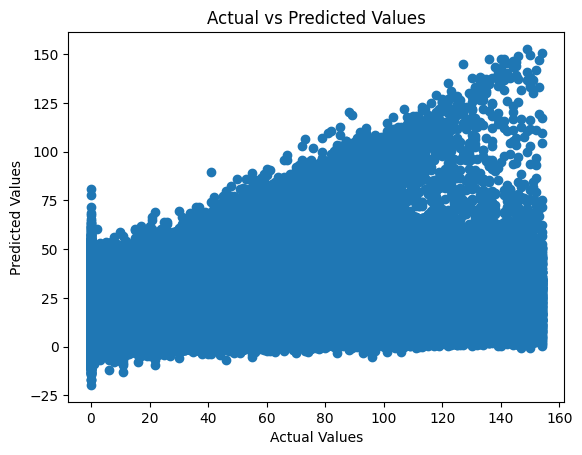

In [59]:
plt.scatter(Y_train, Y_train_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

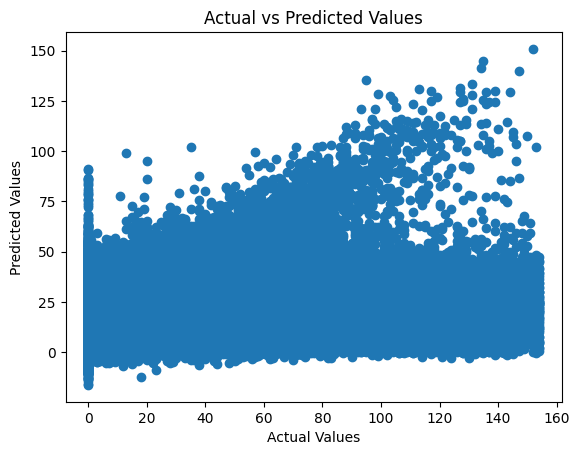

In [60]:
plt.scatter(Y_test, Y_test_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# BUILDING LSTM DATA

In [61]:
X_train_label_lstm = X_train_scale.copy()
X_test_label_lstm = X_test_scale.copy()

X_lstm1 = pd.concat([X_train_label_lstm, Y_train], axis=1)
X_lstm2 = pd.concat([X_test_label_lstm, Y_test], axis=1)

combined_df_lstm = pd.concat([X_lstm1, X_lstm2])

# Sort by date
combined_df_lstm.sort_values(["YEAR", "MONTH", "DAY", "CRS_DEP_TIME", "CRS_ARR_TIME"], inplace=True)

# Features (X_LSTM)
X_LSTM = combined_df_lstm[["YEAR", "MONTH", "DAY", 'AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE', 'TAXI_IN', 'TAXI_OUT']]

# Target variables (Y_LSTM)
Y_LSTM = combined_df_lstm[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_SECURITY', 'DELAY_DUE_NAS', 'DELAY_DUE_LATE_AIRCRAFT']]
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_LSTM, Y_LSTM, test_size=0.25, shuffle=False)

Measuring the longest and shortest list of flights per day to determine whether it makes sense to pad by day. We decided this would not make sense.

In [62]:
longest = 0
shortest = float("inf")
for group in X_train_lstm.groupby(["YEAR", "MONTH", "DAY"]):
  group = group[1]

  if len(group) > longest:
    longest = len(group)

  if len(group) < shortest:
    shortest = len(group)

print(f"longest: {longest} flights")
print(f"shortest: {shortest} flights")

longest: 738 flights
shortest: 10 flights


Saving the datasets

In [63]:
X_train_lstm.to_csv("X_train_lstm.csv", index=False)
X_test_lstm.to_csv("X_test_lstm.csv", index=False)
y_train_lstm.to_csv("Y_train_lstm.csv", index=False)
y_test_lstm.to_csv("Y_test_lstm.csv", index=False)

In [66]:
import tensorflow as tf
import keras
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

Training the LSTM architecture

In [68]:
X_train = pd.read_csv("X_train_lstm.csv")
X_test = pd.read_csv("X_test_lstm.csv")

Y_train = pd.read_csv("Y_train_lstm.csv")
Y_test = pd.read_csv("Y_test_lstm.csv")

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as keras
# Defining callbacks
checkpoint = ModelCheckpoint("models/lstm_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Define LSTM model
# Up to 2 layers of LSTM and number of hidden units were hand tuned to determine this as the optimum model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(units=64, activation='relu', recurrent_dropout=0.2),
    Dense(5)
])

# Use MSE for loss because we want to emphasize the "wrongest" guesses the most. MAE is an interpretable metric
lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

# Train model w/ early stopping
# Batch size is the average number of flights per day
history = lstm_model.fit(X_train, Y_train, epochs=50, batch_size=265, validation_split=0.2, callbacks=[checkpoint, early_stopping])


loss, mae = lstm_model.evaluate(X_test, Y_test)
print("Test Mean Absolute Error:", mae)

Y_pred = lstm_model.predict(X_test)

mae_columns = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
print("Mean Absolute Error for each column:")
print(mae_columns)

Training the LSTM + CNN hybrid architecture

In [ ]:
checkpoint = ModelCheckpoint("../models/hybrid_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Define input layer
input_layer = Input(shape=(X_train.shape[1], 1))

# CNN model
conv_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
maxpool_layer = MaxPooling1D(pool_size=2)(conv_layer)
flatten_layer = Flatten()(maxpool_layer)
dense_cnn = Dense(32, activation='relu')(flatten_layer)

# BiLSTM model
lstm_layer = LSTM(64, activation='relu')(input_layer)
# lstm_layer2 = LSTM(32, activation='relu', return_sequences=False)(lstm_layer)
dense_lstm = Dense(32, activation='relu')(lstm_layer)

# Concatenate CNN and BiLSTM outputs
concatenated = Concatenate()([dense_cnn, dense_lstm])

# Output layer
output_layer = Dense(5)(concatenated)

# Create the ensemble model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

hybrid_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = hybrid_model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=512,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

loss, mae = hybrid_model.evaluate(X_test, Y_test)
print("Test Mean Absolute Error:", mae)

Y_pred = hybrid_model.predict(X_test)

mae_columns = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')
print("Mean Absolute Error for each column:")
print(mae_columns)

Loading LSTM model

In [75]:
lstm_model = keras.models.load_model("models/lstm_model.keras")

In [76]:
Y_pred = lstm_model.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, columns=Y_test.columns)

3827/3827 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step


MSE and MAE

In [77]:
mean_squared_error(Y_test, Y_pred)

360.1238261719237

In [78]:
mean_absolute_error(Y_test, Y_pred)  # these are in mins

9.930893883657196

Standard deviation in each of the columns

In [79]:
for col in Y_pred.columns:
    print(col)
    print(Y_test[col].std(), Y_pred[col].std())

DELAY_DUE_CARRIER
25.567373882084624 6.442824363708496
DELAY_DUE_WEATHER
11.406046218761714 0.8012697696685791
DELAY_DUE_SECURITY
2.422932730882158 0.06321603059768677
DELAY_DUE_NAS
19.65953564135109 11.153653144836426
DELAY_DUE_LATE_AIRCRAFT
29.452996135810928 8.71923828125


Mean of the predictions we made

In [80]:
Y_pred.mean()

,0
DELAY_DUE_CARRIER,15.637125
DELAY_DUE_WEATHER,1.739690
DELAY_DUE_SECURITY,0.084543
DELAY_DUE_NAS,12.603748
DELAY_DUE_LATE_AIRCRAFT,18.176521


### Plotting box plots of predicted test labels and true labels

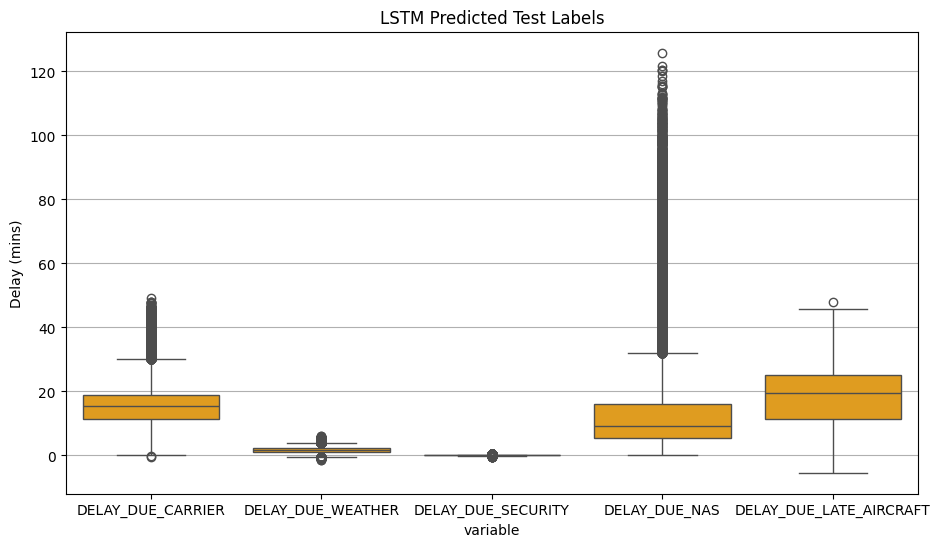

In [82]:
import seaborn as sns
plt.figure(figsize=(11, 6))
plt.grid()
sns.boxplot(Y_pred.melt(), x="variable", y="value", color="orange")
plt.title('LSTM Predicted Test Labels')
plt.ylabel("Delay (mins)")
plt.show()

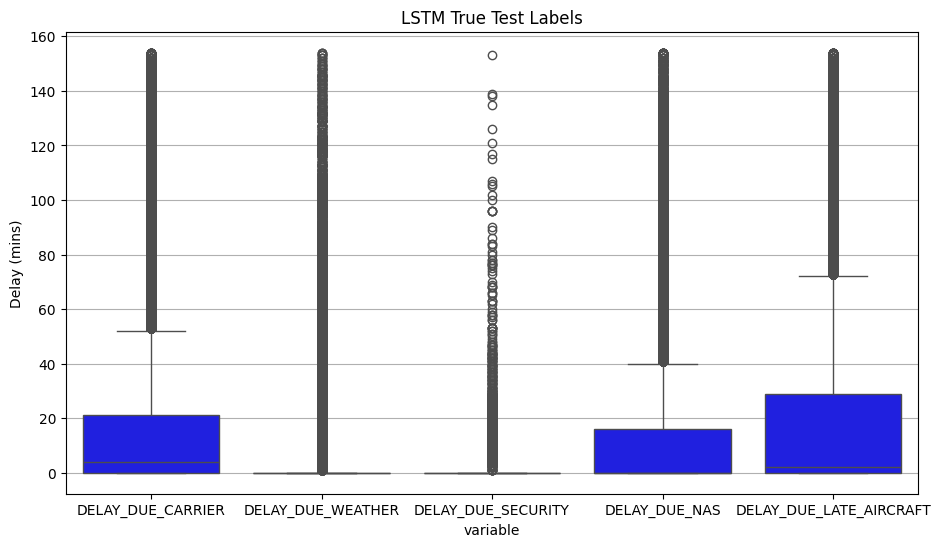

In [83]:
plt.figure(figsize=(11, 6))
plt.grid()
sns.boxplot(Y_test.melt(), x="variable", y="value", color="blue")
plt.title('LSTM True Test Labels')
plt.ylabel("Delay (mins)")
plt.show()

In [84]:
hybrid_model = keras.models.load_model("../models/hybrid_model.keras")

In [85]:
!pip install pydot

In [ ]:
Y_pred = hybrid_model.predict(X_test)

In [ ]:
mean_squared_error(Y_test, Y_pred)

#### Flight Rescheduling

##### Genetic Algorithm Overview ###

A Genetic Algorithm (GA) is a search heuristic that mimics the process of natural selection. This heuristic is routinely used to generate useful solutions to optimization and search problems. The algorithm reflects the process of natural evolution, where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.

Key Concepts

*Population:* A set of potential solutions to the problem.

*Chromosomes:* A representation of a solution. Typically, this is a string of bits, but other representations are possible.

*Genes:* Parts of a chromosome, representing a specific trait of the solution.

*Fitness Function:* A function that evaluates how close a given solution is to the optimum solution of the problem.

*Selection:* The process of choosing the fittest individuals from the population to create offspring.

*Crossover (Recombination):* A genetic operator used to combine the genetic information of two parents to generate new offspring.

*Mutation:* A genetic operator used to maintain genetic diversity within the population by randomly tweaking the genes of individuals.


In [7]:
POPULATION_SIZE = 50  
NUM_GENERATIONS = 100 
MUTATION_RATE = 0.1  
TOURNAMENT_SIZE = 5  

In [20]:
data_day = data[data['FL_DATE'] == '2023-08-31'].copy().reset_index(drop=True)

def calculate_total_delay(crs_dep_times):
    data_day['CRS_DEP_TIME'] = crs_dep_times
    return data_day['DEP_DELAY'].sum()

In [21]:
def initialize_population():
    population = []
    for _ in range(POPULATION_SIZE):
        individual = data_day['CRS_DEP_TIME'].values + np.random.randint(-30, 30, size=len(data_day))
        individual = np.clip(individual, 0, 2359) 
        population.append(individual)
    return population

def tournament_selection(population, scores):
    tournament = random.sample(list(zip(population, scores)), TOURNAMENT_SIZE)
    tournament.sort(key=lambda x: x[1])
    return tournament[0][0]  

def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            individual[i] += np.random.randint(-63, 63)  
            individual[i] = np.clip(individual[i], 0, 2359)  
    return individual

In [22]:
def genetic_algorithm():
    population = initialize_population()
    for generation in range(NUM_GENERATIONS):
        scores = [calculate_total_delay(individual) for individual in population]
        next_generation = []
        for _ in range(POPULATION_SIZE // 2): 
            parent1 = tournament_selection(population, scores)
            parent2 = tournament_selection(population, scores)
            child1, child2 = crossover(parent1, parent2)
            next_generation.append(mutate(child1))
            next_generation.append(mutate(child2))

        population = next_generation
        best_score = min(scores)
        print(f"Generation {generation + 1}, Best Score (Total Delay): {best_score}")
    
    final_scores = [calculate_total_delay(individual) for individual in population]
    best_individual = population[np.argmin(final_scores)]
    best_score = min(final_scores)
    return best_individual, best_score

best_schedule, best_delay = genetic_algorithm()

Generation 1, Best Score (Total Delay): 18974.0
Generation 2, Best Score (Total Delay): 18974.0
Generation 3, Best Score (Total Delay): 18974.0
Generation 4, Best Score (Total Delay): 18974.0
Generation 5, Best Score (Total Delay): 18974.0
Generation 6, Best Score (Total Delay): 18974.0
Generation 7, Best Score (Total Delay): 18974.0
Generation 8, Best Score (Total Delay): 18974.0
Generation 9, Best Score (Total Delay): 18974.0
Generation 10, Best Score (Total Delay): 18974.0
Generation 11, Best Score (Total Delay): 18974.0
Generation 12, Best Score (Total Delay): 18974.0
Generation 13, Best Score (Total Delay): 18974.0
Generation 14, Best Score (Total Delay): 18974.0
Generation 15, Best Score (Total Delay): 18974.0
Generation 16, Best Score (Total Delay): 18974.0
Generation 17, Best Score (Total Delay): 18974.0
Generation 18, Best Score (Total Delay): 18974.0
Generation 19, Best Score (Total Delay): 18974.0
Generation 20, Best Score (Total Delay): 18974.0
Generation 21, Best Score (To

In [23]:
def adjust_time_format(time_array):
    adjusted_times = []
    for time in time_array:
        hh = time // 100
        mm = time % 100
        if mm > 59:
            hh += 1
            mm -= 60
        adjusted_times.append(hh * 100 + mm)
    return np.array(adjusted_times)

best_schedule = adjust_time_format(best_schedule)
# print(best_schedule)

In [24]:
best_schedule_df = data_day[['FL_DATE','AIRLINE', 'FL_NUMBER', 'ORIGIN', 'DEST','CRS_DEP_TIME']].copy()
best_schedule_df['Optimized_CRS_DEP_TIME'] = best_schedule
best_schedule_df.head()

,FL_DATE,AIRLINE,FL_NUMBER,ORIGIN,DEST,CRS_DEP_TIME,Optimized_CRS_DEP_TIME
0,2023-08-31,Frontier Airlines Inc.,2479,IAH,PHX,1517,1639
1,2023-08-31,Republic Airline,5834,LGA,MSN,1993,1951
2,2023-08-31,Southwest Airlines Co.,3188,DEN,AUS,1078,1130
3,2023-08-31,Delta Air Lines Inc.,1850,CLT,ATL,922,926
4,2023-08-31,Delta Air Lines Inc.,531,LAX,DTW,2359,2311
